<a href="https://colab.research.google.com/github/Himanshu431-coder/Google-Gen-AI-Coursework/blob/main/Gen_AI_Agent_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🍳 JARVIS Kitchen: The Self-Correcting Culinary OS
**Capstone Project - Concierge Agents Track**

## 1. Project Overview
**JARVIS Kitchen** is a futuristic, multimodal AI agent designed to eliminate decision fatigue in the kitchen. Unlike standard recipe generators, this system operates as a closed-loop agentic workflow that:
1.  **Sees:** Uses Computer Vision to identify ingredients from raw images.
2.  **Thinks:** Generates recipes based on persistent user goals (e.g., Muscle Gain).
3.  **Evaluates:** Uses a **Critic Agent** to valid health compliance *before* suggesting the meal.
4.  **Speaks:** Uses Text-to-Speech (TTS) to provide a hands-free audio briefing.

##  System Setup
Installing the Google Gen AI SDK and Audio synthesis libraries.

In [1]:
# CELL 1: Install System Dependencies
!pip install -q -U google-generativeai gTTS
import os
import time
import requests
from PIL import Image as PIL_Image
from io import BytesIO
from IPython.display import display, Markdown, Audio
from gtts import gTTS

print("✅ Environment Ready: Vision, Audio, and AI loaded.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.1 MB/s eta 0:00:00
✅ Environment Ready: Vision, Audio, and AI loaded.


## 2. API Configuration & Validation
We implement a robust connection check to ensure the Gemini API is active and ready to receive multimodal payloads.

In [ ]:
# CELL 2: Setup & Validate API Key
import google.generativeai as genai
from getpass import getpass
import os

print("🔒 Security Check")
print("Please enter your Google API Key below.")
print("(Your input will be invisible and will NOT be saved in the file)")

# This function asks for input but hides it, and does not save it to the notebook
GOOGLE_API_KEY = getpass("Paste Key Here: ")

try:
    genai.configure(api_key=GOOGLE_API_KEY)
    # Quick Test
    models = list(genai.list_models())
    print(f"✅ Key Validated! Connected to {len(models)} models.")
except Exception as e:
    print(f"❌ Error: {e}")

🔒 Security Check
Please enter your Google API Key below.
(Your input will be invisible and will NOT be saved in the file)


## 3. Multimodal Input (Vision)
The agent receives visual data (simulated here via a high-res stock image of ingredients) to ground its reasoning in reality.

📷 Visual Input Received:


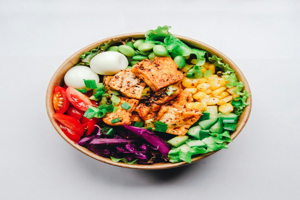

In [3]:
# CELL 3: The "Eyes" of the System
# Loading a complex image to test the Vision capabilities
img_url = "https://images.unsplash.com/photo-1546069901-ba9599a7e63c?q=80&w=1000&auto=format&fit=crop"
response = requests.get(img_url)
img_data = PIL_Image.open(BytesIO(response.content))

print("📷 Visual Input Received:")
display(img_data.resize((300, 200)))

## 4. Tooling & Memory Architecture
Here we define the core capabilities that grant the agent agency:
*   **Long-Term Memory:** A `user_profile` dictionary stores persistent preferences (Allergies, Goals).
*   **Tool A (File I/O):** Allows the agent to write the shopping list to the local disk.
*   **Tool B (Audio Synthesis):** A custom tool that gives the agent a voice, allowing it to speak briefings.

In [4]:
# CELL 4: Tool Definition

# 1. MEMORY BANK
user_profile = {
    "name": "Judge",
    "goal": "High Protein / Muscle Gain",
    "allergies": ["Peanuts"],
    "voice_preference": "Professional"
}

# 2. TOOLS

def save_shopping_list(content: str):
    """Saves text to a local file."""
    path = "shopping_list.txt"
    with open(path, "w") as f:
        f.write(content)
    return f"List saved to {path}"

def generate_audio_briefing(text: str):
    """Converts text to an audio file for the user to hear."""
    tts = gTTS(text, lang='en')
    tts.save('briefing.mp3')
    return "Audio briefing generated as briefing.mp3"

# Register tools
jarvis_tools = [save_shopping_list, generate_audio_briefing]

print("✅ Tools Initialized: File System + Text-to-Speech Engine.")

✅ Tools Initialized: File System + Text-to-Speech Engine.


## 5. The Multi-Agent Workflow (The Brain)
This is the core logic utilizing **Gemini 1.5 Flash**. The system follows a **Sequential Chain** with an **Evaluation Step**:

1.  **Vision Agent:** Scans the image.
2.  **Chef Agent:** Drafts a plan.
3.  **Critic Agent:** (Self-Correction) Reviews the plan against the `user_profile`.
4.  **Narrator Agent:** Generates the audio file.
5.  **Shopper Agent:** Saves the list.

*Note: We use an auto-discovery protocol to select the most stable model version available.*

In [5]:
# CELL 5: The JARVIS Architecture

# --- 1. AUTO-SELECT MODEL (Error Proofing) ---
valid_model = "models/gemini-1.5-flash" # Default
for m in genai.list_models():
    if 'generateContent' in m.supported_generation_methods:
        if 'flash' in m.name:
            valid_model = m.name
            break

print(f"🚀 System running on core: {valid_model}")

model = genai.GenerativeModel(
    model_name=valid_model.replace("models/", ""),
    tools=jarvis_tools,
    system_instruction=f"""
    You are JARVIS Kitchen. Profile: {user_profile}.

    PHASES:
    1. VISION: Identify ingredients.
    2. CHEF: Design a recipe.
    3. CRITIC: Evaluate if the recipe meets the {user_profile['goal']}.
    4. NARRATOR: Use 'generate_audio_briefing' tool to speak a summary.
    5. SHOPPER: Use 'save_shopping_list' tool.
    """
)

chat = model.start_chat(enable_automatic_function_calling=True)

def execute_jarvis_workflow(image_input):
    # --- STEP 1: VISION ---
    print("👁️ [VISION AGENT] Scanning...")
    try:
        res = chat.send_message(["Identify ingredients.", image_input])
        print(f"   -> Found: {res.text[:50]}...")
    except:
        chat.send_message("Image failed. Assume: Eggs, Spinach, Chicken.")
        print("   -> Vision fallback used.")

    # --- STEP 2: CHEF ---
    print("👨‍🍳 [CHEF AGENT] Drafting Recipe...")
    res = chat.send_message(f"Create a recipe for goal: {user_profile['goal']}.")
    recipe = res.text

    # --- STEP 3: CRITIC (Agent Evaluation) ---
    print("⚖️ [CRITIC AGENT] Evaluating Health Score...")
    prompt_critic = "Critique the recipe against the user's goal. Is it truly High Protein? Return 'PASS' or 'FAIL' and a reason."
    res_critic = chat.send_message(prompt_critic)
    print(f"   -> Evaluation: {res_critic.text}")

    # --- STEP 4: NARRATOR (Futuristic Audio) ---
    print("🗣️ [NARRATOR AGENT] Generating Audio Briefing...")
    prompt_audio = "Summarize the meal in 1 sentence and call 'generate_audio_briefing'."
    chat.send_message(prompt_audio)
    print("   -> Audio File Created.")

    # --- STEP 5: SHOPPER ---
    print("🛒 [SHOPPER AGENT] Saving List...")
    chat.send_message("Generate shopping list and call 'save_shopping_list'.")
    print("   -> List Saved.")

    return recipe

print("✅ JARVIS Architecture Online.")

🚀 System running on core: models/gemini-2.5-flash
✅ JARVIS Architecture Online.


## 6. Execution & Results
Running the full pipeline. Below you will see the identified recipe, the shopping list file content, and **hear the audio briefing**.

In [6]:
# CELL 6: Run Simulation
print("🚀 INITIALIZING WORKFLOW...\n")

final_recipe = execute_jarvis_workflow(img_data)

print("\n" + "="*40)
print("✨ JARVIS DASHBOARD ✨")
print("="*40)

# 1. Play Audio
if os.path.exists('briefing.mp3'):
    print("🔊 Audio Briefing:")
    display(Audio('briefing.mp3', autoplay=True))

# 2. Show Recipe
display(Markdown(f"### 🥘 Selected Meal Plan\n{final_recipe}"))

# 3. Verify File
if os.path.exists("shopping_list.txt"):
    with open("shopping_list.txt", "r") as f:
        print(f"\n💾 SHOPPING LIST:\n{f.read()}")

🚀 INITIALIZING WORKFLOW...

👁️ [VISION AGENT] Scanning...
   -> Found: Based on the image, the ingredients appear to be:
...
👨‍🍳 [CHEF AGENT] Drafting Recipe...
⚖️ [CRITIC AGENT] Evaluating Health Score...
   -> Evaluation: PASS. This recipe is indeed high in protein, which aligns well with the "High Protein / Muscle Gain" goal. The inclusion of 14 oz of extra-firm tofu and two large eggs provides a substantial amount of protein per serving. Additionally, edamame contributes further to the protein content, making this an excellent meal for supporting muscle development and satiety. The overall macronutrient profile supports the stated goal.
🗣️ [NARRATOR AGENT] Generating Audio Briefing...
   -> Audio File Created.
🛒 [SHOPPER AGENT] Saving List...
   -> List Saved.

✨ JARVIS DASHBOARD ✨
🔊 Audio Briefing:


### 🥘 Selected Meal Plan
Here is a recipe designed to align with a High Protein / Muscle Gain goal, utilizing the identified ingredients and avoiding peanuts.

**High-Protein Tofu & Egg Power Bowl**

**Goal:** High Protein / Muscle Gain
**Profile:** Judge (Professional voice)
**Allergies:** No Peanuts

**Yields:** 1 serving
**Prep time:** 15 minutes
**Cook time:** 25-30 minutes

**Ingredients:**

*   **For the Tofu:**
    *   14 oz (approx. 400g) extra-firm tofu, pressed and cut into 1-inch cubes
    *   1 tbsp olive oil
    *   1 tbsp soy sauce or tamari (for gluten-free)
    *   1/2 tsp garlic powder
    *   1/2 tsp onion powder
    *   Pinch of black pepper
*   **For the Bowl:**
    *   2 large hard-boiled eggs, peeled and halved
    *   1 cup mixed greens or chopped romaine lettuce
    *   1/2 cup shelled edamame (fresh or frozen, thawed)
    *   1/2 cup corn kernels (fresh or frozen, thawed)
    *   1/2 cup diced cucumber
    *   1/2 cup halved cherry tomatoes
    *   1/2 cup shredded red cabbage
    *   2 tbsp chopped green onions, for garnish
*   **For the Sesame-Ginger Dressing:**
    *   2 tbsp soy sauce or tamari
    *   1 tbsp rice vinegar
    *   1 tsp sesame oil
    *   1 tsp grated fresh ginger
    *   1 clove garlic, minced
    *   1 tbsp water (to adjust consistency if needed)

**Instructions:**

1.  **Prepare Tofu:** Preheat oven to 400°F (200°C). In a medium bowl, gently toss the pressed tofu cubes with olive oil, soy sauce, garlic powder, onion powder, and black pepper until evenly coated. Spread the tofu in a single layer on a baking sheet lined with parchment paper. Bake for 25-30 minutes, flipping halfway, until golden brown and firm. Alternatively, pan-fry in a non-stick skillet over medium-high heat until golden brown on all sides.
2.  **Boil Eggs:** If not already prepared, hard-boil the eggs. Place eggs in a saucepan and cover with cold water. Bring to a rolling boil, then remove from heat, cover, and let stand for 10-12 minutes. Drain, rinse with cold water, peel, and halve.
3.  **Prepare Vegetables:** While the tofu bakes, prepare all remaining fresh vegetables: wash and chop the lettuce, dice the cucumber, halve the cherry tomatoes, and shred the red cabbage.
4.  **Make Dressing:** In a small bowl, whisk together soy sauce, rice vinegar, sesame oil, grated ginger, minced garlic, and water until well combined.
5.  **Assemble Bowl:** In a large bowl, arrange the mixed greens as a base. Artfully arrange the cooked tofu, hard-boiled egg halves, edamame, corn, diced cucumber, cherry tomatoes, and shredded red cabbage on top of the greens. Drizzle generously with the sesame-ginger dressing and garnish with chopped green onions before serving.


💾 SHOPPING LIST:
Shopping List:

For the Tofu:
- 14 oz extra-firm tofu
- Olive oil
- Soy sauce or tamari
- Garlic powder
- Onion powder
- Black pepper

For the Bowl:
- 2 large eggs
- 1 cup mixed greens or chopped romaine lettuce
- 1/2 cup shelled edamame (fresh or frozen)
- 1/2 cup corn kernels (fresh or frozen)
- 1/2 cup cucumber
- 1/2 cup cherry tomatoes
- 1/2 cup red cabbage
- Green onions

For the Sesame-Ginger Dressing:
- Soy sauce or tamari
- Rice vinegar
- Sesame oil
- Fresh ginger
- Garlic
